In [1]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy accelerate smalldiffusion tqdm diffusers transformers xformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 9.9 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import torchvision.transforms.v2.functional as TF
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn
from torchvision.utils import save_image, make_grid
from smalldiffusion import ModelMixin, ScheduleLDM
from collections import namedtuple
from itertools import pairwise
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

# Introduction
In this exercise you will implement a custom sampler for a pretrained text-to-image diffusion model (Stable Diffusion 2.1). The goal is to modify classifier-free guidance during the sampling process to:

  1. Generate a series of images that interpolates between two different text prompts
  2. Generate visual illusions -- images that match different text prompts when viewed from different orientations

Stable Diffusion is a [latent diffusion model](https://arxiv.org/abs/2112.10752), where the diffusion process (with a 2D-Unet denoiser model) occurs in a (4x64x64)-dimensional latent space, guided by a text embedding from a pretrained [CLIP model](https://arxiv.org/abs/2103.00020) and tokenizer. The diffusion output in latent-space is decoded into a (3x512x512)-dimeisional pixel-space image with a pretrained variational autoencoder (VAE).

First we define a wrapper class for all of these models, which will handle the text encoding and VAE decoding after the diffusion process. We also load the model from a checkpoint.

In [3]:
def alpha_bar(sigma):
    return 1/(sigma**2+1)

def show_tensor(x):
    display(TF.to_pil_image(x))

class ModelLatentDiffusion(nn.Module, ModelMixin):
    def __init__(self, model_key, accelerator=None):
        super().__init__()
        self.accelerator = accelerator or Accelerator()
        self.vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder")
        self.unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
        self.input_dims = (self.unet.config.in_channels, self.unet.sample_size, self.unet.sample_size,)
        self.text_condition = None
        self.text_guidance_scale = None
        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        self.to(self.accelerator.device)

    def tokenize(self, prompt):
        return self.tokenizer(
            prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors='pt'
        ).input_ids.to(self.accelerator.device)

    def embed_prompt(self, prompt):
        with torch.no_grad():
            return self.text_encoder(self.tokenize(prompt))[0]

    @torch.no_grad()
    def decode_latents(self, latents):
        decoded = self.vae.decode(latents / 0.18215).sample
        normalized = (decoded.squeeze()+1)/2 # from [-1,1] to [0, 1]
        return normalized.clamp(0,1)

    def sigma_to_t(self, sigma):
        idx = torch.searchsorted(reversed(self.scheduler.alphas_cumprod.to(sigma)), alpha_bar(sigma))
        return self.scheduler.config.num_train_timesteps - 1 - idx

    def forward(self, x, sigma, cond=None):
        z = alpha_bar(sigma).sqrt() * x
        return self.unet(z, self.sigma_to_t(sigma), encoder_hidden_states=cond).sample

model = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

# Sampling with classifier-free guidance

Next, we provide a starter sampler code that implements classifier-free guidance. Given $e_0$ (embedding of the empty text prompt, or a negative prompt) and $e_1$ (embedding of the target text prompt) and a guidance scale $\gamma$, classifier-free guidance is implemented as:

$$\bar{\epsilon}_t = (1-\gamma) \epsilon(x_t, \sigma_t, e_0) + \gamma \epsilon(x_t, \sigma_t, e_1)$$

torch.Size([1, 77, 1024])


20it [00:10,  1.95it/s]


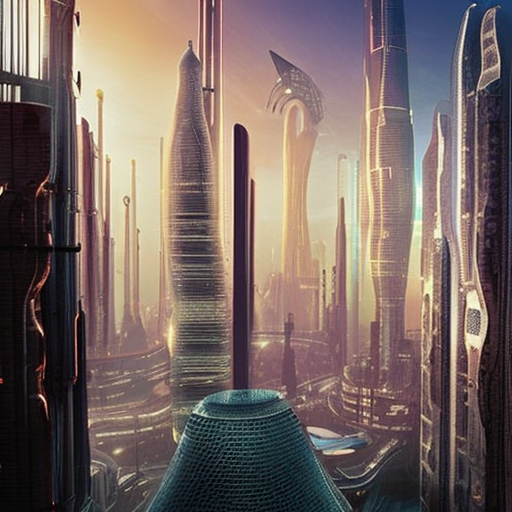

In [28]:
def sample_cfg(model,
               prompt     = 'An astronaut riding a horse',
               neg_prompt = '',
               cfg_scale  = 7.5,
               N          = 50,
               gam        = 1.,
               mu         = 0.,
               seed       = 0,):
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed text prompt and negative prompt
    embed, neg_embed = map(model.embed_prompt, (prompt, neg_prompt))

    print(embed.shape)

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt twice, conditioned on `prompt` and `neg_prompt` respectively
        with torch.no_grad():
            eps_pred = model.predict_eps(xt, sig.to(xt), embed)
            eps_pred_neg = model.predict_eps(xt, sig.to(xt), neg_embed)

        # Do classifier-free guidance
        eps_prev, eps = eps, (1-cfg_scale) * eps_pred_neg + cfg_scale * eps_pred

        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
    return model.decode_latents(xt)

img = sample_cfg(model,
    prompt = 'A photograph of a futuristic city',
    neg_prompt = 'low resolution',
    cfg_scale  = 7,
    gam=1.5, mu=0., N=20, seed=0,
)
show_tensor(img)

# Question 1 (3 points): Interpolation

We can modify classifier-free guidance to interpolate between two different text prompts $e_1$ and $e_2$. This is done by combining the guidance terms and varying the guidance scales $\gamma_1$ and $\gamma_2$:


$$\bar{\epsilon}_t = (1-\gamma_1-\gamma_2) \epsilon(x_t, \sigma_t, e_0) + \gamma_1 \epsilon(x_t, \sigma_t, e_1) + \gamma_2 \epsilon(x_t, \sigma_t, e_2)$$

Implement a version of `sample_cfg` that takes in multiple prompts and guidance scales and performs classifier-free guidance using the different prompts. Code to call this sampler is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [104]:
def sample_multi_prompt(model,
                        prompts    = ['An astronaut riding a horse',
                                      'low resolution, blurry image, bad composition'],
                        cfg_scales = [7.5, -6.5],
                        N          = 50,
                        gam        = 1.,
                        mu         = 0.,
                        seed       = 0,):

    ### YOUR CODE HERE ###
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed text prompt and negative prompt
    #embed = model.embed_prompt(prompts)
    embed_0, embed_1, embed_2 = map(model.embed_prompt, (prompts[0], prompts[1], prompts[2]))

    #print(embed.shape)

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None
    #eps_pred = []

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt twice, conditioned on `prompt` and `neg_prompt` respectively
        with torch.no_grad():
            #for n in range(embed.shape[0]):
            #eps_pred_0 =  model.predict_eps(xt, sig.to(xt), embed[n].unsqueeze(0)))
            eps_pred_0 =  model.predict_eps(xt, sig.to(xt), embed_0)
            eps_pred_1 =  model.predict_eps(xt, sig.to(xt), embed_1)
            eps_pred_2 =  model.predict_eps(xt, sig.to(xt), embed_2)

        # Do classifier-free guidance
        eps_prev, eps = eps, (1-cfg_scales[0]-cfg_scales[1]) * eps_pred_0 + cfg_scales[0] * eps_pred_1  + cfg_scales[1] * eps_pred_2


        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
    return model.decode_latents(xt)

20it [00:14,  1.36it/s]


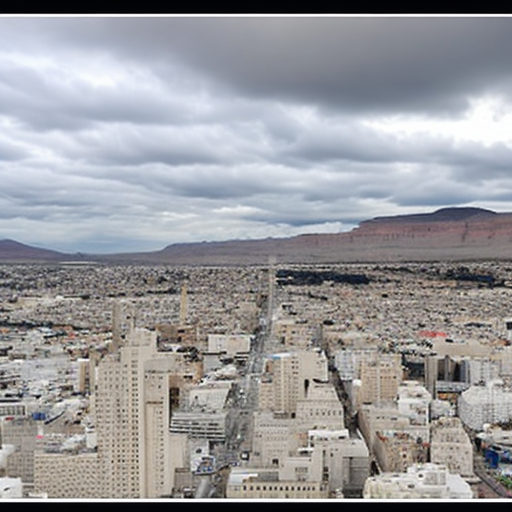

20it [00:15,  1.30it/s]


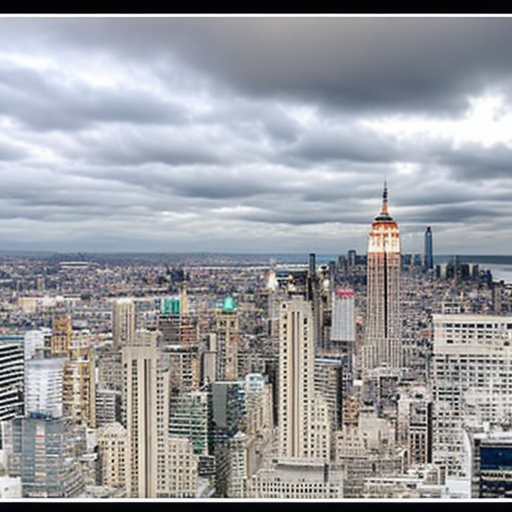

20it [00:15,  1.28it/s]


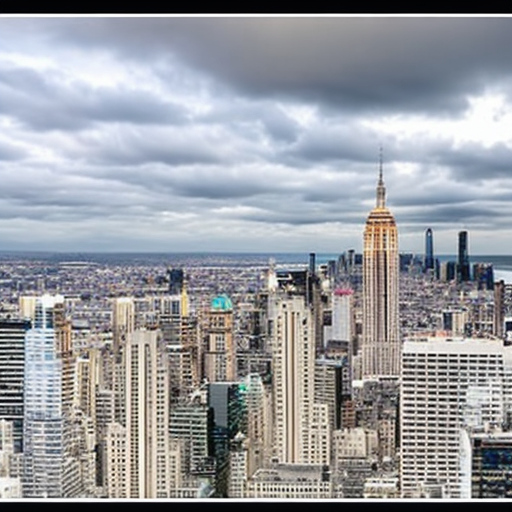

20it [00:15,  1.31it/s]


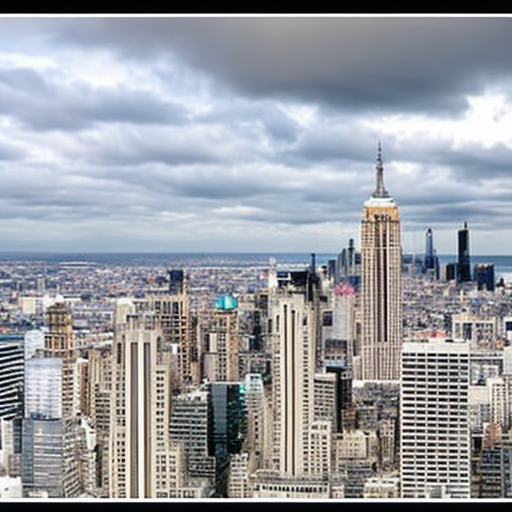

20it [00:14,  1.34it/s]


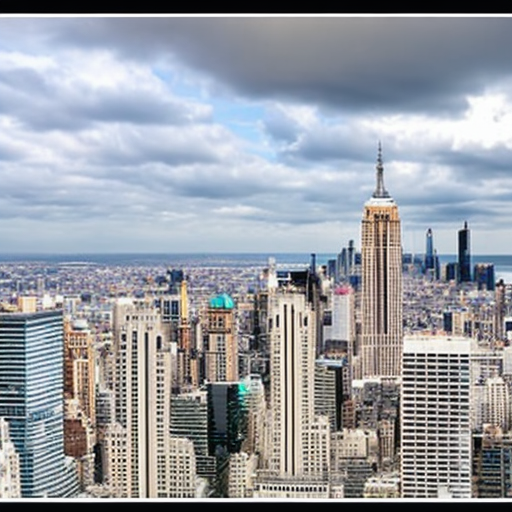

20it [00:14,  1.35it/s]


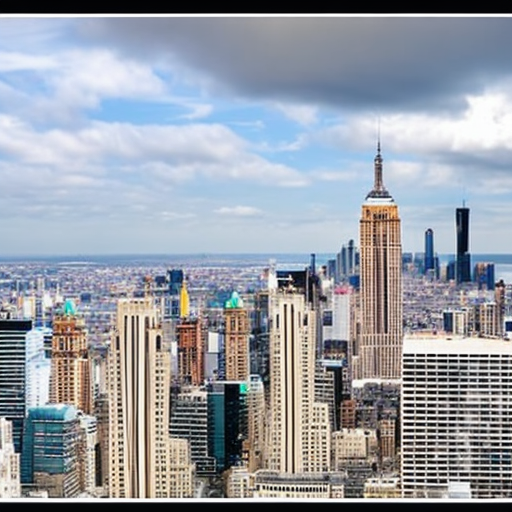

20it [00:14,  1.34it/s]


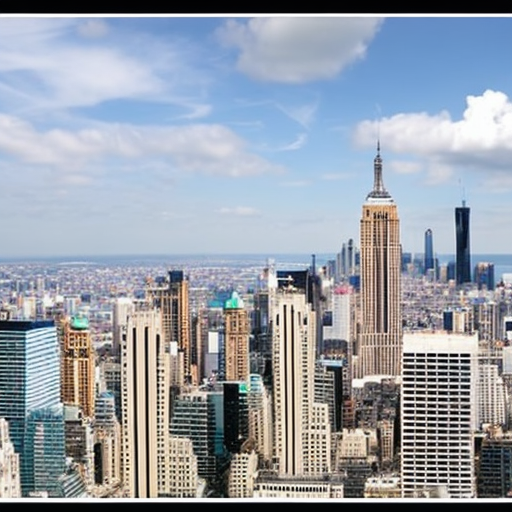

20it [00:15,  1.32it/s]


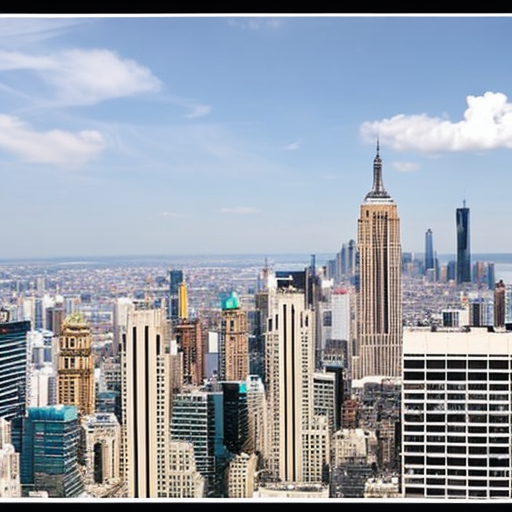

20it [00:15,  1.32it/s]


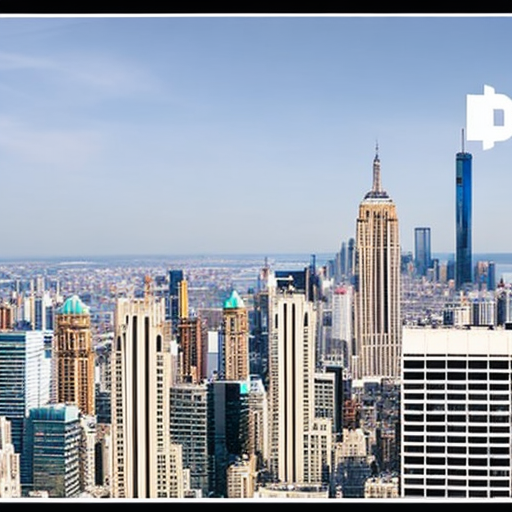

20it [00:15,  1.32it/s]


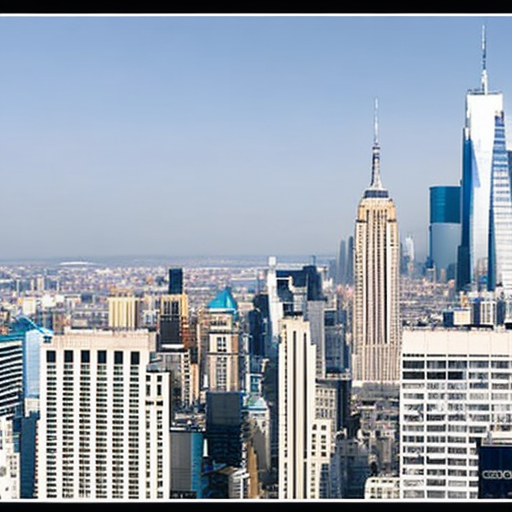

In [106]:
# Modify the `sample_multi_prompt` function above to take in multiple prompts and scales,
# enabling interpolation between two text prompts
'''prompts= ['low resolution, blurry image, bad composition',
                  'House in the woods, oil painting, ghibli inspired, high resolution',
                  'Building in a futuristic city, oil painting, ghibli inspired, high resolution'],'''
for i, scale in enumerate(np.linspace(0, 4, 10)):
    img = sample_multi_prompt(
        model, gam=1.7, N=20, seed=7,
        #prompts = ['A photograph of a futuristic city', 'A photograph of a current city', 'A photograph of a man'],
        prompts= ['low resolution, blurry image, bad composition',
                  'House in the woods, oil painting, ghibli inspired, high resolution',
                  'Building in a futuristic city, oil painting, ghibli inspired, high resolution'],
        cfg_scales =(-7, 2+scale, 6-scale),
    )
    show_tensor(img)

# Question 2 (3 points): Visual Illusions

We can also use classifier-free guidance to produce images that look like text prompt $e_1$ after applying transformation $t_1$ (e.g. a rotation), but also looks like text prompt $e_2$ after applying transformation $t_2$. This technique is further explored in the [visual anagrams paper](https://dangeng.github.io/visual_anagrams/); we will implement a basic version of it.


The main idea is to apply transform $t_1$ to the $x_t$ before applying classifier-free guidance conditioned on $e_1$, then applying its inverse $t_1^{-1}$ to the output. The same is done with $t_2$ and $e_2$.

$$
\begin{align*}
\bar{\epsilon}^1_t &= t_1^{-1}((1-\gamma) \epsilon(t_1(x_t), \sigma_t, e_0) + \gamma \epsilon(t_1(x_t), \sigma_t, e_1)) \\
\bar{\epsilon}^2_t &= t_2^{-1}((1-\gamma) \epsilon(t_2(x_t), \sigma_t, e_0) + \gamma \epsilon(t_2(x_t), \sigma_t, e_2))
\end{align*}
$$

The two outputs are then averaged:

$$\bar{\epsilon}_t = \frac{1}{2} (\bar{\epsilon}^1_t +\bar{\epsilon}^2_t)$$

Modify your sampler above to apply different transformations for different text prompts. Code to call this sampler to generate and display a visual illusion is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [119]:
def sample_transforms(model,
                      prompts  = ['An astronaut riding a horse',
                                  'low resolution, blurry image, bad composition'],
                      cfg_scales = [7.5, -6.5],
                      transforms = None,
                      N          = 50,
                      gam        = 1.,
                      mu         = 0.,
                      seed       = 0,):

    ### YOUR CODE HERE ###
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed text prompt and negative prompt
    #embed = model.embed_prompt(prompts)
    embed_0, embed_1 = map(model.embed_prompt, (prompts[0], prompts[1]))

    #print(embed.shape)

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None
    #eps_pred = []

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt twice, conditioned on `prompt` and `neg_prompt` respectively
        with torch.no_grad():
            #for n in range(embed.shape[0]):
            print(transforms)
            xt_trans_1 = transforms[0].fwd(xt)
            eps_pred_0 =  model.predict_eps(xt_trans_1, sig.to(xt_trans_1), embed_0)

            xt_trans_2 = transforms[0].fwd(xt)
            eps_pred_1 =  model.predict_eps(xt_trans_2, sig.to(xt_trans_2), embed_1)

        # Do classifier-free guidance
        eps_prev_1  = transforms[0].inv((1-cfg_scales[0]) * eps_pred_0 + cfg_scales[0] * eps_pred_0)
        eps_prev_2  = transforms[0].inv((1-cfg_scales[0]) * eps_pred_1 + cfg_scales[0] * eps_pred_1)


        eps_prev, eps = eps, 1/2*(eps_prev_1 + eps_prev_1)

        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
    return model.decode_latents(xt)

0it [00:00, ?it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


1it [00:00,  1.95it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


2it [00:01,  2.00it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


3it [00:01,  2.00it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


4it [00:01,  2.01it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


5it [00:02,  2.00it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


6it [00:03,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


7it [00:03,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


8it [00:04,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


9it [00:04,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


10it [00:05,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


11it [00:05,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


12it [00:06,  1.99it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


13it [00:06,  1.98it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


14it [00:07,  1.97it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


15it [00:07,  1.97it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


16it [00:08,  1.97it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


17it [00:08,  1.96it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


18it [00:09,  1.97it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


19it [00:09,  1.96it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


20it [00:10,  1.96it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


21it [00:10,  1.95it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


22it [00:11,  1.95it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


23it [00:11,  1.94it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


24it [00:12,  1.95it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


25it [00:12,  1.94it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


26it [00:13,  1.94it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


27it [00:13,  1.93it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


28it [00:14,  1.93it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


29it [00:14,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


30it [00:15,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


31it [00:15,  1.93it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


32it [00:16,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


33it [00:16,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


34it [00:17,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


35it [00:17,  1.92it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


36it [00:18,  1.91it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


37it [00:18,  1.91it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


38it [00:19,  1.91it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


39it [00:20,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


40it [00:20,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


41it [00:21,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


42it [00:21,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


43it [00:22,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


44it [00:22,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


45it [00:23,  1.89it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


46it [00:23,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


47it [00:24,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


48it [00:24,  1.90it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


49it [00:25,  1.89it/s]

(Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>), Transform(fwd=<function <lambda> at 0x7f51b5d64d60>, inv=<function <lambda> at 0x7f51b5d66160>), Transform(fwd=<function <lambda>.<locals>.<lambda> at 0x7f51b5d67240>, inv=<function <lambda>.<locals>.<lambda> at 0x7f51b5d65620>))


50it [00:25,  1.94it/s]


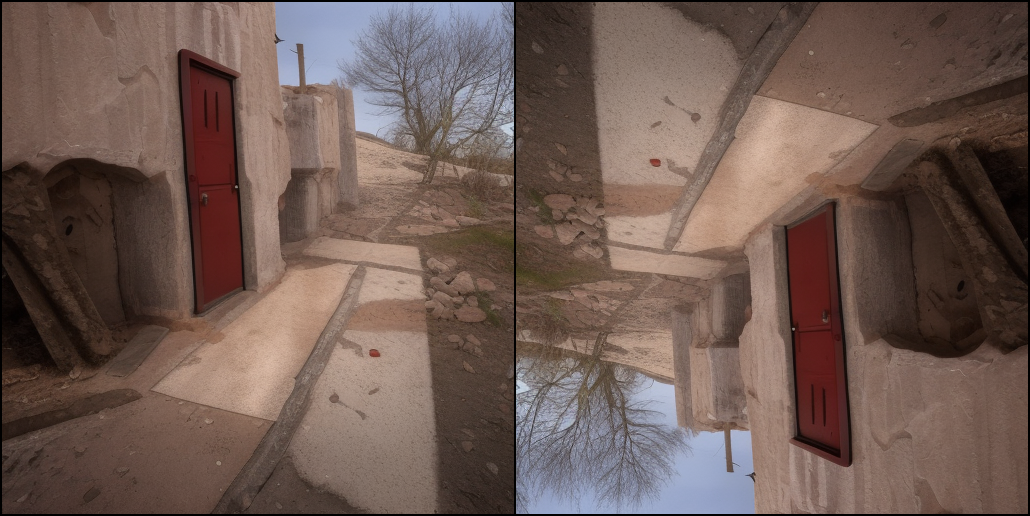

In [120]:
# Define transforms used for illusions
Transform = namedtuple('Transform', ['fwd', 'inv'])
id_t = Transform(lambda x:x, lambda x:x)
r = lambda r: lambda x: TF.rotate(x, r)
rot_180 = Transform(r(180), r(-180))

transforms = (id_t, rot_180, id_t, rot_180)

# Modify the `sample_transforms` function above to take in multiple transforms and
# apply them during classifer-free guidance
img = sample_transforms(
    model, gam=1.2, mu=0.5, N=50, seed=0,
    prompts=('', '', # Unconditional null-text prompts
            'A painting of a snowy mountain', 'A painting of a horse'),
    transforms = transforms,
    cfg_scales = (-3, -3, 3.5, 3.5),
)
imgs_t = [t.fwd(img) for t in transforms[2:]]
show_tensor(make_grid(torch.stack(imgs_t)))